In [1]:
import pickle
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
import sys
import os
import math
# import matplotlib as plt
import os.path
import matplotlib.pyplot as plt
import operator
import numpy as np
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import astropy.io.fits as fits
import matplotlib.lines as lines
# from Luhman_Plot_View_Def import * 

In [2]:
# def choose_fourier(nmode):
#     def fourier_model(x,*fp):
#         fourier = fp[1] ##setting the offset first.
# #         print(fourier)
#         for i in range(nmode):
#             n=i+1
#             fourier = fourier + fp[2+i*2]*np.cos(2.*np.pi*n*x/fp[0]) + fp[3+i*2]*np.sin(2.*np.pi*n*x/fp[0])
#         return(fourier)
#     return(fourier_model)

# def choose_f_ipsv(nmodes,maxorder):
#     def f_ipsv_model(xyt_arr,*p):
#         x=xyt_arr[0,:]
#         y=xyt_arr[1,:]
#         t=xyt_arr[2,:]
#         xy = np.array([x,y])
# #       functions to find the number of parameters for each model.
#         n_ipsv=0
#         for i in range(maxorder):#parameters for ipsv
#             n_ipsv = n_ipsv +(i+2) 
            
#         n_f = (2+2*(nmodes)) #parameters for fourier
# #         print(n_f,n_ipsv)
# #       splitting up actual parameter ( p ) according to model (ipsv then fourier parameters)
#         p_ipsv = p[0:n_ipsv]
#         p_f = p[n_ipsv::]
# #         print(p)
#         ipsv_model = choose_ipsv(maxorder)(xy,*p_ipsv)
#         f_model = choose_fourier(nmodes)(t,*p_f)
#         model = ipsv_model *f_model
#         return(model)
#     return(f_ipsv_model)

def receive_ascii_data(initial_time,dir_lightcurv,part_str,col):
    col_1='AperturePhot';col_2='bmjd';col_3='x_com_cen';col_4='y_com_cen'
    data = ascii.read(dir_lightcurv)
    ap_phot = data[col_1]
    bmjd = data[col_2]
    xcen=data[col_3]
    ycen=data[col_4]
    i_t =(bmjd-initial_time)*24
#     ap_phot=median_flux(ap_phot)## important to comment when you want to view all segments in line.
    plt.plot(i_t,ap_phot,'.',label=part_str,color=col)
    return(ap_phot,i_t,xcen,ycen)

def median_flux(ap_ph_seg,full_LC):
    median_flux = np.nanmean(full_LC)
#     print(median_flux)
    ap_ph_med = ap_ph_seg/median_flux
    
    return ap_ph_med

def choose_f_ipsv(nmodes,maxorder,Npoly):
    def f_ipsv_model(xyt_arr,*p):
        x=xyt_arr[0,:]
        y=xyt_arr[1,:]
        t=xyt_arr[2,:]
        xy = np.array([x,y])
#       functions to find the number of parameters for each model.
        n_ipsv=0
        for i in range(maxorder):#parameters for ipsv
            n_ipsv = n_ipsv +(i+2) 
        n_f = (Npoly+1)*(2*nmodes+1)+1 #parameters for fourier
#         print(n_f,n_ipsv)
#       splitting up actual parameter ( p ) according to model (ipsv parameters first then fourier parameters)
        p_ipsv = p[0:n_ipsv]
        p_f = p[n_ipsv::]
#         print(p_ipsv)
#         print(p_f)
        ipsv_model = choose_ipsv(maxorder)(xy,*p_ipsv)
        f_model = choose_fourier_jr(nmodes,Npoly)(t,*p_f)
        model = ipsv_model *f_model
        return(model)
    return(f_ipsv_model)

def choose_fourier_jr(nmode, npoly):
    def fourier_model(x,*fp):
# This is a Fourier definetion where the a and b are a functions of time( f(t) equals to polynomial of t). 
# Npoly is the order of the polynomial.
        fp2 = fp[1:]#extracts the period
        a0_coeffs = fp2[0:npoly+1]
#         print('Printing a0 coeff:',a0_coeffs)#Printing a0 coeff.
        fourier = np.polyval(a0_coeffs, x) ##setting the offset first.
#         print(fourier)
        for k in range(nmode):
            n=k+1
            an_coeffs = fp2[npoly+1+(npoly+1)*2*k:npoly+(npoly+1)+1+(npoly+1)*2*k]
            bn_coeffs = fp2[npoly+1+(npoly+1)+n*2*(npoly+1)*2**k:npoly+(npoly+1)*2+1+(npoly+1)*2*k]
            
            fourier = fourier+np.polyval(an_coeffs,x)*np.cos(2.*np.pi*n*x/fp[0]) +np.polyval(bn_coeffs,x)*np.sin(2.*np.pi*n*x/fp[0])
        return(fourier)
    return(fourier_model)


def choose_ipsv(maxorder):
    def ipsv_model(xy_arr,*p):
        x=xy_arr[0,:]
        y=xy_arr[1,:]
        x_bar=np.mean(xy_arr[0,:])
        y_bar=np.mean(xy_arr[1,:])
        
        index_ipsv = 0
        ipsv = 1
        for i in range(maxorder):
            order=i+1
            loop_order=i+2
            for j in range(loop_order):
                ipsv=ipsv+p[index_ipsv]*(x-x_bar)**(order-j)*(y-y_bar)**(j)
                index_ipsv=index_ipsv+1
#         print(index_ipsv)
        return(ipsv)
    return(ipsv_model)

def bin_funct(data_arr,nbin):
    data= data_arr.data
    print(data)
    bins=len(data)
    binned_data = [np.mean(data[i*nbin:i*nbin+nbin]) for i in range(1,bins//nbin+1)]
    return binned_data


def clip_of_mask_flux(clip_flux):
    clip = sigma_clip(clip_flux, sigma=sigma_num, sigma_lower=None, sigma_upper=None, iters=5, cenfunc=np.ma.median, stdfunc=np.std, axis=None, copy=True)
    clipped = clip[np.logical_not(clip.mask)] - 1.
    return clipped

def clip_of_mask (clp_med_flux, x):
    clip = sigma_clip(clp_med_flux, sigma=sigma_num, sigma_lower=None, sigma_upper=None, iters=5, cenfunc=np.ma.median, stdfunc=np.std, axis=None, copy=True)
    clipped_x = x[np.logical_not(clip.mask)]
    return clipped_x  

def clip_arr(data,time,xcen,ycen,sigma):
    sigma_num = sigma
#     Calls previous definition functions and plots them
#     This is to make the code more neater.
    clip_flux = clip_of_mask(data,data)
    clip_time = clip_of_mask(data,time)
    clip_xcen = clip_of_mask(data,xcen)
    clip_ycen = clip_of_mask(data,ycen)
#     arr=np.array([clip_flux,clip_time,clip_xcen,clip_ycen]) 
    return (clip_flux,clip_time,clip_xcen,clip_ycen)

def ExtArrFunct(x3,x5,x1,x4,x7,x2,x6_1):
    final_arr=[]
    ch1_arr=[]
    ch2_arr=[]
    final_arr.extend(x3);ch1_arr.extend(x3)
    final_arr.extend(x5);ch2_arr.extend(x5)
    final_arr.extend(x1);ch1_arr.extend(x1)
    final_arr.extend(x4);ch2_arr.extend(x4)
    final_arr.extend(x7);ch1_arr.extend(x7)
    final_arr.extend(x2);ch2_arr.extend(x2)
    final_arr.extend(x6_1);ch1_arr.extend(x6_1)
    Tot_arr_table = Column(final_arr, name='Column')#change its type from list to astropy column to mask data points
    ch1_arr_table = Column(ch1_arr, name='Column')
    ch2_arr_table = Column(ch2_arr, name='Column')
    return Tot_arr_table,ch1_arr_table,ch2_arr_table

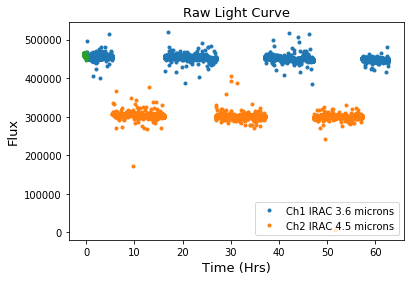

In [3]:
created_dir ='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com_test'
name_of_file_last = '/com_ap_ph_prt'
fileN= created_dir+name_of_file_last

lightcurve_1='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt1/bcdfits_com_part_1.txt'
lightcurve_2='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt2/bcdfits_com_part_2.txt'
lightcurve_3='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt3/bcdfits_com_part_3.txt'
lightcurve_4='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt4/bcdfits_com_part_4.txt'
lightcurve_5='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt5/bcdfits_com_part_5.txt'
lightcurve_6_1='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt6-1/bcdfits_com_part_6-1.txt'
lightcurve_6_2='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt6-2/bcdfits_com_part_6-2.txt'
lightcurve_7='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt7/bcdfits_com_part_7.txt'

data = ascii.read(lightcurve_3)
bmjd = data['bmjd']
initial_time =bmjd[0]

plt.figure(figsize=(6,4))
plt.ylabel('Flux',fontsize = 13)
plt.xlabel('Time (Hrs)',fontsize = 13)
plt.title('Raw Light Curve',fontsize = 13)
ap_ph_1,bmjd_1,x_cen1,y_cen1= receive_ascii_data(initial_time,lightcurve_1,'Ch1 IRAC 3.6 microns','C0')
ap_ph_2,bmjd_2,x_cen2,y_cen2= receive_ascii_data(initial_time,lightcurve_2,'Ch2 IRAC 4.5 microns','C1');plt.legend(loc='lower right')
ap_ph_3,bmjd_3,x_cen3,y_cen3= receive_ascii_data(initial_time,lightcurve_3,'CH1 Part 3','C0')
ap_ph_4,bmjd_4,x_cen4,y_cen4= receive_ascii_data(initial_time,lightcurve_4,'CH2 Part 4','C1')
ap_ph_5,bmjd_5,x_cen5,y_cen5= receive_ascii_data(initial_time,lightcurve_5,'CH2 Part 5','C1')
ap_ph_6_1,bmjd_6_1,x_cen6_1,y_cen6_1= receive_ascii_data(initial_time,lightcurve_6_1,'CH1 Part 6-1','C0')
ap_ph_6_2,bmjd_6_2,x_cen6_2,y_cen6_2= receive_ascii_data(initial_time,lightcurve_6_2,'CH1 Part 6-2','C2')#Will not be included
ap_ph_7,bmjd_7,x_cen7,y_cen7= receive_ascii_data(initial_time,lightcurve_7,'CH1 Part 7','C0')

# # -----------------------------------------------------------
# add="Raw_Light_curve.png"
# save_figure = "/Users/melaniapena/Desktop/"+add
# plt.savefig(save_figure,dpi=300)

In [4]:
import warnings
warnings.filterwarnings("ignore")

Parameters for Fourier model:  19
Parameters for IPSV model:  5
Done


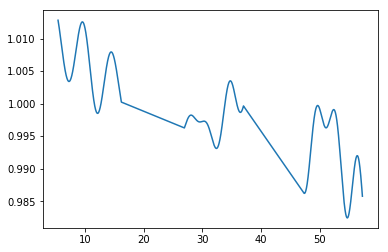

In [5]:
# -------------------------------------------------------------------------------------------------------------
#choose the mode and order for Fourier and IPSV polynomial
maxorder = 2; nmodes = 4; period = 14; sigma_num=5 #nbin_num=63
# -------------------------------------------------------------------------------------------------------------
##Taking out the info from the the ASCII directory array.
## This also clips the data and takes the median of the flux array.

# Takes the segments of the light curve and sets them all within 
# the same array and creates three types. This goes the Ligght curve,
# time, and centroids
# All, CH1, CH2.
ap_ph, ch1_ap_ph, ch2_ap_ph = ExtArrFunct(ap_ph_3,ap_ph_5,ap_ph_1,ap_ph_4,ap_ph_7,ap_ph_2,ap_ph_6_1)
hr, ch1_hr, ch2_hr = ExtArrFunct(bmjd_3,bmjd_5,bmjd_1,bmjd_4,bmjd_7,bmjd_2,bmjd_6_1)
xcen, ch1_xcen, ch2_xcen = ExtArrFunct(x_cen3,x_cen5,x_cen1,x_cen4,x_cen7,x_cen2,x_cen6_1)
ycen, ch1_ycen, ch2_ycen = ExtArrFunct(y_cen3,y_cen5,y_cen1,y_cen4,y_cen7,y_cen2,y_cen6_1)

# Take the median of the full light curve 
ch1_ap_ph=median_flux(ch1_ap_ph,ch1_ap_ph)
ch2_ap_ph=median_flux(ch2_ap_ph,ch2_ap_ph)

# plt.plot(ch1_hr,ch1_ap_ph,'.')
# plt.plot(ch2_hr,ch2_ap_ph,'.')
# plt.ylim(.90,1.09)
# plt.show()

# Clipped the data
c_f1,c_h1,c_xcen1,c_ycen1=clip_arr(ch1_ap_ph,ch1_hr,ch1_xcen,ch1_ycen,sigma_num);#plt.plot(c_h1,c_f1,'.',color='C4')
c_f2,c_h2,c_xcen2,c_ycen2=clip_arr(ch2_ap_ph,ch2_hr,ch2_xcen,ch2_ycen,sigma_num);#plt.plot(c_h2,c_f2,'.',color='C2')
# -------------------------------------------------------------------------------------------------------------
c_f=c_f2
c_h=c_h2
c_xcen=c_xcen2
c_ycen=c_ycen2
# -------------------------------------------------------------------------------------------------------------
### ONLY FOURIER MODEL (ASTROPHYSICAL MODEL)
# n_f = 2+2*(nmodes)
Npoly=1
n_f = (Npoly+1)*(2*nmodes+1)+1
print('Parameters for Fourier model: ',n_f) ## number of paramters for number of fourier terms

### guess parameters for fourier
guess_fourier = np.zeros(n_f)
guess_fourier = np.random.randn(n_f)*0.01
# print(guess_fourier)
number = period
period_guess=number#/24 omitted
offset_guess=1
guess_fourier[0] = period_guess
guess_fourier[1+Npoly] = offset_guess
# or 
# guess_fourier=np.array([0,-2.89578827e-04,0,4.86380215e-05,-3.07081145e-03, 
#                        1.00000000e-02,  3.07084653e-07,6.25705014e-05, -3.94045270e-03 ,7.00000000e-02,
#                         7.00000000e-02, -8.67333527e-05,4.21064040e-03 , 9.20000000e-03  ,2.00000000e-04,
#                         1.91028868e-05,1.61330428e-04,  7.00000000e-02,  7.00000000e-02  ,7.00000000e-02,
#                         7.00000000e-02 , 7.00000000e-02,  7.00000000e-02])
# guess_fourier[0] = 1.39012135e+01
# guess_fourier[1+Npoly] = offset_guess

# -------------------------------------------------------------------------------------------------------------
## ONLY IPSV MODEL
n_ipsv=0
for i in range(maxorder):
    n_ipsv=n_ipsv +(i+2)
print('Parameters for IPSV model: ',n_ipsv) ## number of parameters for ipsv polynomial
# guess parameters for ipsv
guess_ipsv = np.zeros(n_ipsv)
guess_ipsv = np.random.randn(n_ipsv)*0.01
xy_arr=np.array([c_xcen,c_ycen]) ##centroids in table array for curve fit

# -------------------------------------------------------------------------------------------------------------
### FULL MODEL (ASTROPHYSICAL AND IPSV MODEL)
# Will be using the same guess parameters from ipsv and fourier

guess_params = np.append(guess_ipsv,guess_fourier)
xyt_arr=np.array([c_xcen,c_ycen,c_h]) ### setting time, x centroid , and y centroid into the same table array.

# Using the Curve fit for the model.
full_params, covar = curve_fit(choose_f_ipsv(nmodes,maxorder,Npoly),xyt_arr,c_f,p0=guess_params)

# -------------------------------------------------------------------------------------------------------------
### Keeping the parameters consistent.
fullp_ipsv = full_params[0:n_ipsv]
fullp_f = full_params[n_ipsv::]

model_f = choose_fourier_jr(nmodes,Npoly)(c_h,*fullp_f)
model_ipsv = choose_ipsv(maxorder)(xy_arr,*fullp_ipsv)
model_final = choose_f_ipsv(nmodes,maxorder,Npoly)(xyt_arr,*full_params)
print('Done')
# # # -------------------------------------------------------------------------------------------------------------
plt.plot(c_h,model_f)

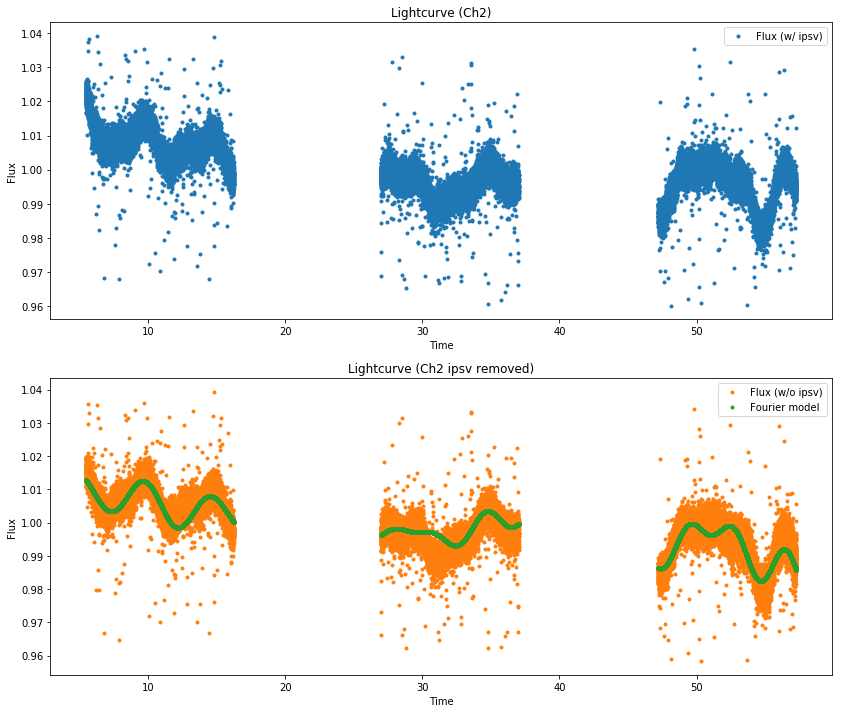

In [7]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
def limit(val,ran):
    val_in = val-ran
    val_fi = val+ran
    return(val_in,val_fi)
plt.figure(figsize=(14,12))
setv=22;ran=6;#print('Guess: ',guess_fourier);print('\nSet:',fullp_f)
flux_no_ipsv = c_f/model_ipsv
# Note: on limit def there's part3(2.5,3)...part1(21.5,6)..part7(42,6)...part6(60,3)
# Uses the the sigma clip and clips out data points that are too far.
ax = plt.subplot(gs[0,:])
# i,f=limit(setv,ran);plt.xlim(i,f);plt.ylim(.95,1.05);
plt.title('Lightcurve (Ch2)');plt.xlabel('Time');plt.ylabel('Flux')
plt.plot(c_h,c_f,'.',label='Flux (w/ ipsv)',color='C0')
plt.legend(loc='upper right')
#Clipped flux where they divide out the ipsv portion of the data and has already
ax = plt.subplot(gs[1,:])
# i,f=limit(setv,ran);plt.xlim(i,f);plt.ylim(.95,1.05);
plt.title('Lightcurve (Ch2 ipsv removed)');plt.xlabel('Time');plt.ylabel('Flux')
plt.plot(c_h,flux_no_ipsv,'.',label='Flux (w/o ipsv)',color='C1')
plt.plot(c_h,model_final/model_ipsv,'.',label='Fourier model',color='C2')
plt.legend(loc='upper right')
# plt.plot(c_h,model_ipsv)

Std:  0.002715692042086245
Total Parameters: 24
Chi_Sqaured: 106372.51649564417
Length of Flux:  54077
Chi-Sqrd/len(Flux):  1.967056539668328
BIC:  1.9718932714462711


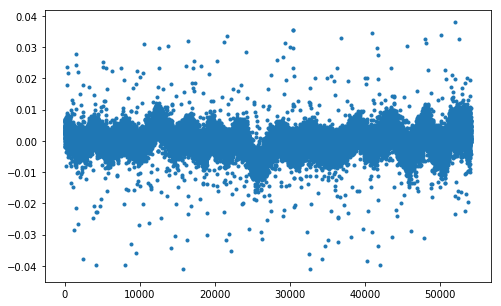

In [307]:
def chi_sqrd(Model, Data, unc):
    two = 2
    chi_squared = sum(((Data - Model) ** two) / unc ** two)
    return chi_squared
# This gives noise from the data
flux_roll = np.roll(c_f,1)
diff = flux_roll - c_f
f_stdev = np.std(diff) / np.sqrt(2)
print('Std: ',f_stdev) ## noise is for each data point 0.2%

chi_2 = chi_sqrd(model_final,c_f,f_stdev)
len_c_f = len(c_f)
chi_val = round(chi_2,3)
chi_div_len_fl = chi_2/(len(c_f))
round_chi_div_len_fl = round(chi_div_len_fl,4)

# The BIC formula:
total_param = n_ipsv+n_f
BIC = round(chi_2 + (np.log(len_c_f)*(total_param)),5)

plt.figure(figsize=(8,5))
print('Total Parameters:',total_param)
print('Chi_Sqaured:',chi_2)
print('Length of Flux: ',len(c_f))
print('Chi-Sqrd/len(Flux): ',chi_2/(len(c_f)))
print('BIC: ', BIC/(len(c_f)))
res = c_f - model_final
plt.plot(res,'.',label='Light Curve')

In [299]:
# nbin_num=63

# c_fbin = bin_funct(flux_no_ipsv,nbin_num)
# c_hbin = bin_funct(c_h,nbin_num)
# # c_cenx_bin = bin_funct(c_xcen,nbin_num)
# # c_ceny_bin = bin_funct(c_ycen,nbin_num)

# plt.figure(figsize=(7,5))
# # i,f=limit(42,6);plt.xlim(i,f)
# plt.title('Binned Light Curve',fontsize=15);plt.xlabel('Time (Hrs)',fontsize=14);plt.ylabel('Flux',fontsize=14)
# plt.plot(c_hbin,c_fbin,'.',label='Ch1 Binned Light Curve');

In [ ]:
# if lightcurve == lightcurve_1: 
#     lightcurve = 'lightcurve_1'
# elif lightcurve == lightcurve_2:
#     lightcurve = 'lightcurve_2'
# elif lightcurve == lightcurve_3:
#     lightcurve = 'lightcurve_3'
# elif lightcurve == lightcurve_4:
#     lightcurve = 'lightcurve_4'
# elif lightcurve == lightcurve_5:
#     lightcurve = 'lightcurve_5'
# elif lightcurve == lightcurve_6_1:
#     lightcurve = 'lightcurve_6_1'
# elif lightcurve == lightcurve_7:
#     lightcurve = 'lightcurve_7'
# pickle_file= '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/pickle_LC/'
# if not os.path.exists(pickle_file):
#     os.makedirs(pickle_file)
# dir_pickle =pickle_file+'pickle_'+lightcurve+'.pickle'
# with open(dir_pickle, 'wb') as f:
#     pickle.dump([c_fbin_2,c_hbin,c_cenx_bin,c_ceny_bin], f)    

In [ ]:
-0.01618341 -0.00865246 -0.00140078 -0.00347467  0.00536604  0.01499865
  0.00277085 -0.01898035  0.00816676 -0.02173541  0.0054774 ##ch2
    
    [-0.01392218 -0.01598712 -0.01255945 -0.00651429 -0.00580956 -0.00779548
  0.0010969   0.00970075  0.01195967 -0.00446841 -0.00026089##ch1